**Telecom X 2**
**ARCHIVO DE ENTRADA: dataFinal.csv (dataset limpio de la Parte 1)**

1. Preparación de datos (drop columnas, OHE, balance, escalado)
2. Correlación y selección exploratoria
3. Modelos predictivos (con y sin normalización) + métricas
4. Análisis de importancia de variables (coeficientes e importancias)

In [2]:
#PRIMERO IMPORTAMOS LAS LIBRERIAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Para balanceo EN CASO HAYA DESBALANCE FUERTE

from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (7,5)

1. 🛠️ PREPARACIÓN DE LOS DATOS
- Carga CSV limpio (resultado de la Parte 1).
- Elimina columnas irrelevantes (IDs, etc.).
- Asegura que variables categóricas estén numéricas (One-Hot Encoding).
- Calcula proporción de clases (Churn True/False) y decide si aplicar SMOTE.
- Define si es necesario escalar: lo haremos solo para modelos sensibles a escala.

In [4]:
df = pd.read_csv("dataFinal.csv")

# ---------- Quitar columnas irrelevantes ----------
# Si existe un identificador único, quitarlo (ajusta nombres si aplica en tu CSV).
cols_drop = [c for c in df.columns if c.lower() in {"customerid", "id", "cliente_id", "customer_id"}]
if cols_drop:
    df.drop(columns=cols_drop, inplace=True)

In [5]:

# ---------- Asegurar tipo de Churn ----------
# Tus datos ya traen Churn como booleano True/False. Igual dejamos un mapeo defensivo:
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes": True, "No": False, "True": True, "False": False}).astype(bool)

# ---------- One-Hot Encoding a categóricas ----------
# Identificamos columnas no numéricas (excluyendo la target)
feature_cols = [c for c in df.columns if c != "Churn"]
cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# ---------- Revisión rápida de nulos y duplicados ----------
print("\n[Chequeo] Nulos por columna:")
print(df_encoded.isnull().sum().sort_values(ascending=False).head(10))
print("\n[Chequeo] Filas duplicadas:", df_encoded.duplicated().sum())

# Si hubiera nulos extremos
# df_encoded.fillna(df_encoded.median(numeric_only=True), inplace=True)




[Chequeo] Nulos por columna:
Churn                           0
cust_SeniorCitizen              0
cust_Partner                    0
cust_Dependents                 0
Tiempo en la empresa (Meses)    0
phone_PhoneService              0
acc_PaperlessBilling            0
acc_Charges.Monthly             0
acc_Charges.Total               0
Cargo_Diario                    0
dtype: int64

[Chequeo] Filas duplicadas: 179


In [6]:
#Proporción de clases
print("\n[Clase] Distribución Churn (conteo):")
print(df_encoded["Churn"].value_counts())
print("\n[Clase] Distribución Churn (%):")
print((df_encoded["Churn"].value_counts(normalize=True) * 100).round(2))


[Clase] Distribución Churn (conteo):
Churn
False    5398
True     1869
Name: count, dtype: int64

[Clase] Distribución Churn (%):
Churn
False    74.28
True     25.72
Name: proportion, dtype: float64


In [7]:
# Heurística: si la clase minoritaria < 35%, consideramos aplicar SMOTE
minority_pct = df_encoded["Churn"].value_counts(normalize=True).min()
APLICAR_SMOTE = minority_pct < 0.35  # puedes forzar True/False según necesidad
print(f"\n¿Aplicar SMOTE? -> {APLICAR_SMOTE} (minoría={minority_pct:.2%})")


¿Aplicar SMOTE? -> True (minoría=25.72%)


In [8]:
#Train/Test Split (70/30 o 80/20)
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"].astype(int)  # Para métricas y correlación

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [9]:
#Balanceo con SMOTE solo en train
if APLICAR_SMOTE:
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print("\n[SMOTE] Nueva distribución en train:")
    print(pd.Series(y_train).value_counts(normalize=True).round(3))


[SMOTE] Nueva distribución en train:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [10]:
#Escalado (solo para modelos sensibles a escala: LR, KNN, SVM, etc.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#🎯 CORRELACIÓN Y SELECCIÓN DE VARIABLES

- Calcula y visualiza la matriz de correlación (numéricas).
- Inspecciona relaciones específicas: Tenure x Churn, TotalCharges x Churn (boxplots/scatter).

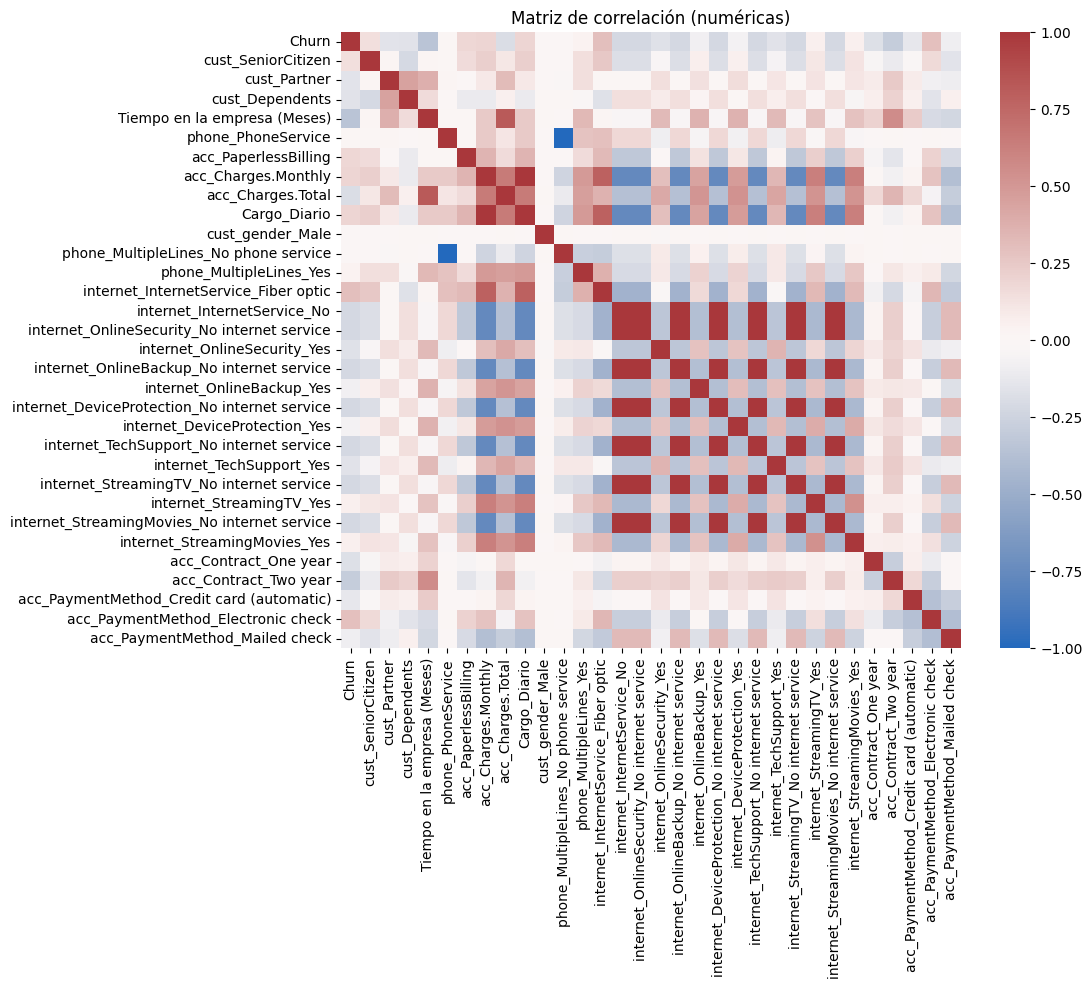

In [11]:
#Matriz de correlación
corr = df_encoded.assign(Churn=y).corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0)
plt.title("Matriz de correlación (numéricas)")
plt.show()

In [14]:
#VAMOS A IDENTIFICIAR LAS COLUMNAS CANDIDATAS
# Buscamos nombres típicos tanto del dataset original
posibles_tenure = [c for c in df_encoded.columns if ("tenure" in c.lower()) or ("tiempo en la empresa" in c.lower())]
posibles_total = [c for c in df_encoded.columns if ("totalcharges" in c.lower()) or ("acc_charges.total" in c.lower())]

col_tenure = posibles_tenure[0] if posibles_tenure else None
col_total = posibles_total[0] if posibles_total else None

col_total

'acc_Charges.Total'

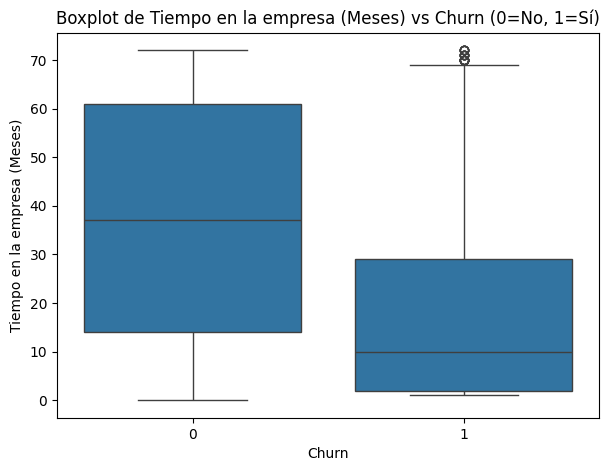

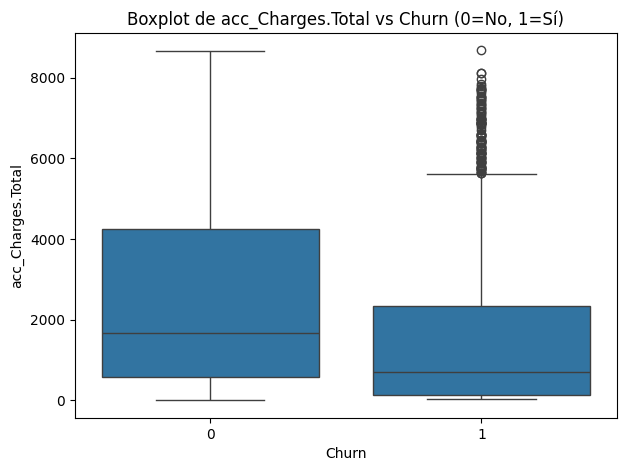

In [15]:
#Boxplots: variable vs Churn
def boxplot_vs_churn(colname):
    if colname and colname in df_encoded.columns:
        sns.boxplot(x=y, y=df_encoded[colname])
        plt.title(f"Boxplot de {colname} vs Churn (0=No, 1=Sí)")
        plt.xlabel("Churn")
        plt.ylabel(colname)
        plt.show()

boxplot_vs_churn(col_tenure)
boxplot_vs_churn(col_total)

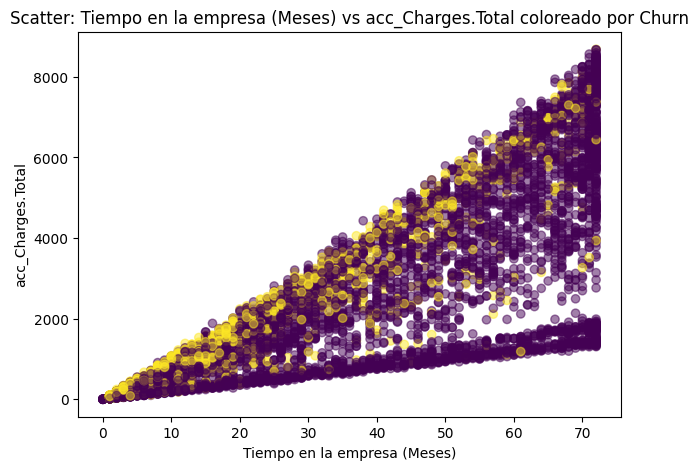

In [16]:
#Dispersión si ambas existen
if col_tenure and col_total:
    plt.scatter(df_encoded[col_tenure], df_encoded[col_total], c=y, alpha=0.5)
    plt.title(f"Scatter: {col_tenure} vs {col_total} coloreado por Churn")
    plt.xlabel(col_tenure); plt.ylabel(col_total)
    plt.show()

#👩‍💻 MODELOS PREDICTIVOS

- Entrenamos 2+ modelos:
(A) Regresión Logística (con normalización)
(B) KNN (con normalización)
(C) Random Forest (sin normalización)
Métricas: accuracy, precision, recall, f1, y matriz de confusión.
- Comentarios sobre normalización:
- LR/KNN: sensibles a la escala -> usamos X_train_scaled/X_test_scaled
- RF: no requiere escalado -> usamos X_train/X_test (sin escalar)

In [17]:
def evaluar_modelo(y_true, y_pred, nombre):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {nombre} ===")
    print(classification_report(y_true, y_pred, zero_division=0, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión — {nombre}")
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.show()
    return {"modelo": nombre, "accuracy": acc, "precision": pre, "recall": rec, "f1": f1}


=== Regresión Logística (scaled) ===
              precision    recall  f1-score   support

           0      0.866     0.824     0.845      1620
           1      0.555     0.633     0.591       561

    accuracy                          0.775      2181
   macro avg      0.711     0.728     0.718      2181
weighted avg      0.786     0.775     0.779      2181



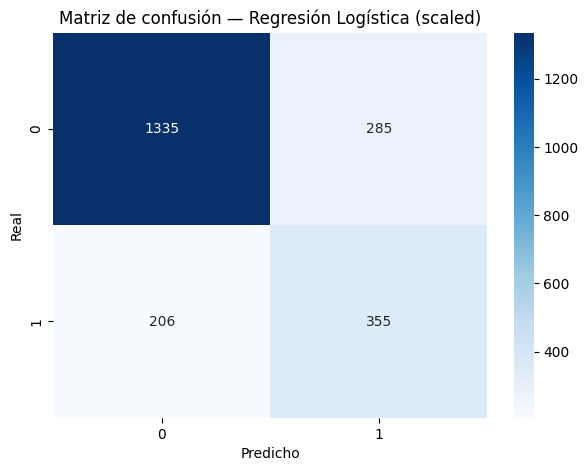

In [18]:
#(A) Regresión Logística (normalizada)
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)
pred_log = log_reg.predict(X_test_scaled)
res_log = evaluar_modelo(y_test, pred_log, "Regresión Logística (scaled)")


=== KNN (scaled, k=7) ===
              precision    recall  f1-score   support

           0      0.850     0.764     0.805      1620
           1      0.473     0.611     0.533       561

    accuracy                          0.725      2181
   macro avg      0.662     0.688     0.669      2181
weighted avg      0.753     0.725     0.735      2181



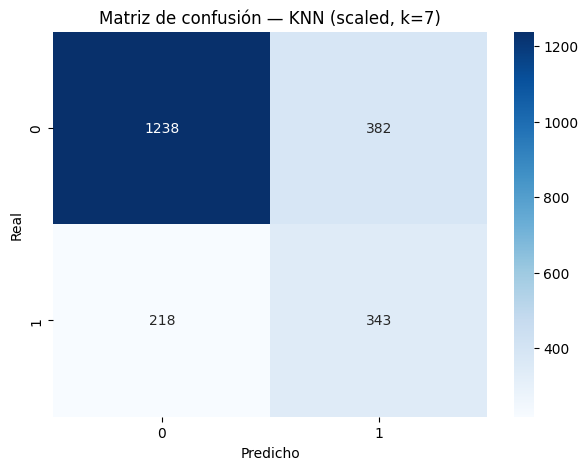

In [19]:
#(B) KNN (normalizado)
knn = KNeighborsClassifier(n_neighbors=7, weights="distance")  # k=7 es un buen inicio
knn.fit(X_train_scaled, y_train)
pred_knn = knn.predict(X_test_scaled)
res_knn = evaluar_modelo(y_test, pred_knn, "KNN (scaled, k=7)")

In [20]:
#(C) Random Forest (sin normalizar)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42
)


=== Random Forest (no scaled) ===
              precision    recall  f1-score   support

           0      0.844     0.857     0.850      1620
           1      0.567     0.542     0.554       561

    accuracy                          0.776      2181
   macro avg      0.705     0.699     0.702      2181
weighted avg      0.773     0.776     0.774      2181



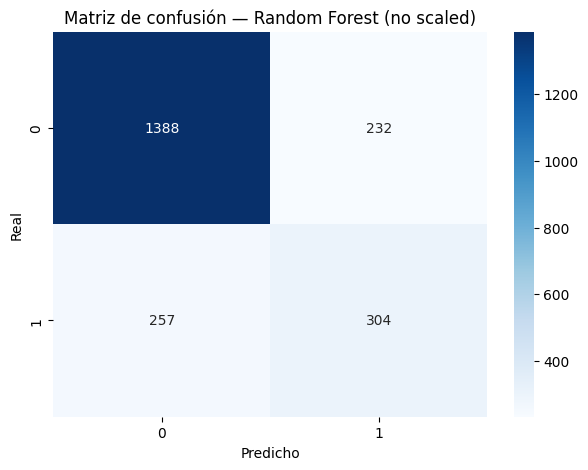

In [21]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
res_rf = evaluar_modelo(y_test, pred_rf, "Random Forest (no scaled)")

In [22]:
#Comparativo de métricas
comparacion = pd.DataFrame([res_log, res_knn, res_rf]).sort_values("f1", ascending=False)
print("\nCOMPARACIÓN DE MODELOS (ordenado por F1):")
print(comparacion)


COMPARACIÓN DE MODELOS (ordenado por F1):
                         modelo  accuracy  precision    recall        f1
0  Regresión Logística (scaled)  0.774874   0.554688  0.632799  0.591174
2     Random Forest (no scaled)  0.775791   0.567164  0.541889  0.554239
1             KNN (scaled, k=7)  0.724897   0.473103  0.611408  0.533437


#🔎 ANÁLISIS DE VARIABLES RELEVANTES
- Regresión Logística: ver coeficientes (signo y magnitud indican impacto sobre odds de churn).
- Random Forest: importancia de variables (reducción de impureza).
- KNN: no tiene coeficientes/importancias directas (comentado en análisis).



Top 15 coeficientes positivos (aumentan prob. de churn) — LR:
                                     variable  coeficiente
12       internet_InternetService_Fiber optic     4.423970
4                          phone_PhoneService     3.069642
25               internet_StreamingMovies_Yes     1.700635
10       phone_MultipleLines_No phone service     1.679788
23                   internet_StreamingTV_Yes     1.623254
7                           acc_Charges.Total     1.374678
11                    phone_MultipleLines_Yes     0.975068
19              internet_DeviceProtection_Yes     0.798179
17                  internet_OnlineBackup_Yes     0.712081
29         acc_PaymentMethod_Electronic check     0.630486
15                internet_OnlineSecurity_Yes     0.568181
21                   internet_TechSupport_Yes     0.530018
5                        acc_PaperlessBilling     0.332601
30             acc_PaymentMethod_Mailed check     0.329211
28  acc_PaymentMethod_Credit card (automatic)     0.

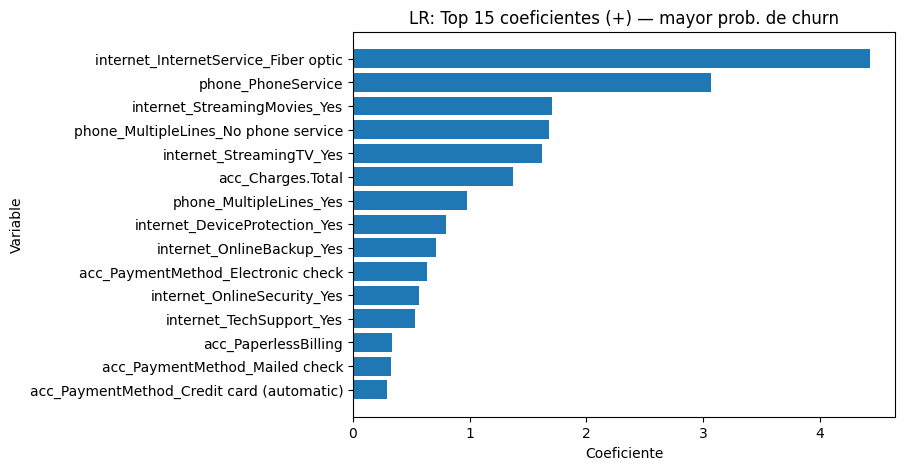

In [23]:
#Coeficientes LR
coef_lr = pd.DataFrame({
    "variable": X.columns,
    "coeficiente": log_reg.coef_[0]
}).sort_values("coeficiente", ascending=False)

print("\nTop 15 coeficientes positivos (aumentan prob. de churn) — LR:")
print(coef_lr.head(15))
print("\nTop 15 coeficientes negativos (reducen prob. de churn) — LR:")
print(coef_lr.tail(15))

plt.barh(coef_lr.head(15)["variable"][::-1], coef_lr.head(15)["coeficiente"][::-1])
plt.title("LR: Top 15 coeficientes (+) — mayor prob. de churn")
plt.xlabel("Coeficiente"); plt.ylabel("Variable")
plt.show()


Top 20 importancias — Random Forest:
                                     variable  importancia
7                           acc_Charges.Total     0.146849
3                Tiempo en la empresa (Meses)     0.139371
6                         acc_Charges.Monthly     0.104967
8                                Cargo_Diario     0.103293
29         acc_PaymentMethod_Electronic check     0.097468
12       internet_InternetService_Fiber optic     0.051472
5                        acc_PaperlessBilling     0.045491
27                      acc_Contract_Two year     0.039489
11                    phone_MultipleLines_Yes     0.021593
9                            cust_gender_Male     0.020846
26                      acc_Contract_One year     0.017486
1                                cust_Partner     0.016895
25               internet_StreamingMovies_Yes     0.016346
23                   internet_StreamingTV_Yes     0.016119
28  acc_PaymentMethod_Credit card (automatic)     0.015275
21                

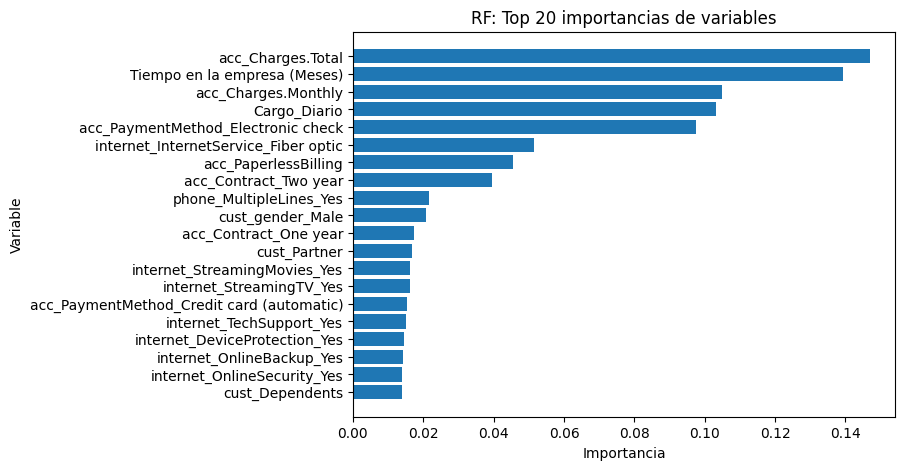

In [24]:
#Importancias RF
imp_rf = pd.DataFrame({
    "variable": X.columns,
    "importancia": rf.feature_importances_
}).sort_values("importancia", ascending=False)

print("\nTop 20 importancias — Random Forest:")
print(imp_rf.head(20))

plt.barh(imp_rf.head(20)["variable"][::-1], imp_rf.head(20)["importancia"][::-1])
plt.title("RF: Top 20 importancias de variables")
plt.xlabel("Importancia"); plt.ylabel("Variable")
plt.show()

#**Informe Final del Proyecto de Análisis de Datos – Telecomunicaciones**

**1. Objetivo del Proyecto**

El propósito principal de este trabajo fue procesar, limpiar y analizar una base de datos de clientes de una empresa de telecomunicaciones, con el fin de identificar patrones relevantes en la información, tales como ingresos, cancelaciones, distribución por categorías y variables demográficas.

El proyecto buscó:

Preparar un dataset limpio y confiable.

Explorar las principales variables (numéricas y categóricas).

Identificar tendencias clave que puedan servir a la empresa para la toma de decisiones.

**2. Proceso de Limpieza de Datos**

Se trabajó inicialmente con un dataset crudo (telecom.csv) que presentaba problemas como:

Valores nulos.

Datos inconsistentes en algunas columnas.

Duplicados.

Tipos de datos incorrectos.

Acciones realizadas:

Carga inicial de datos con pandas.

Inspección preliminar usando:

df.info() para revisar tipos de variables.

df.isnull().sum() para identificar valores faltantes.

Eliminación/Imputación de valores nulos según la relevancia de las variables.

Corrección de tipos de datos (ejemplo: fechas convertidas con pd.to_datetime).

Eliminación de duplicados con df.drop_duplicates().

Normalización de categorías (ejemplo: estandarización de valores “Yes/No”, “Male/Female”).

Al final de esta fase se generó un dataset limpio llamado dataFinal.csv, el cual fue la base para el análisis.

**3. Análisis Exploratorio de Datos (EDA)***

Se realizaron análisis tanto de variables categóricas como numéricas.

3.1 Variables Categóricas

Se analizaron con value_counts() y gráficas de barras.
Ejemplos de hallazgos:

Distribución de género de clientes (masculino vs femenino).

Porcentaje de clientes que se dieron de baja (churn).

Métodos de pago más utilizados.

3.2 Variables Numéricas

Se trabajó con histogramas, boxplots y medidas estadísticas.
Hallazgos importantes:

Ingresos concentrados en ciertos rangos, con outliers en clientes de alto consumo.

Relación entre ingresos y probabilidad de baja de clientes.

3.3 Tablas de Frecuencia

Se usó pd.cut() para agrupar ingresos en clases y construir tablas de frecuencias absolutas y relativas, lo cual permitió visualizar mejor la distribución del ingreso de los clientes.

Ejemplo de código:

frecuencia = pd.cut(x=df['ingresos'], bins=clases, labels=labels, include_lowest=True)

**4. Exportación de Resultados**

El dataset limpio final fue guardado como:
📂 dataFinal.csv

Esto permite reutilizar los datos en futuros análisis, modelos predictivos o dashboards en Power BI/Tableau.

**5. Conclusiones**

El proceso de limpieza de datos fue esencial para asegurar la confiabilidad del análisis.

Se identificó que las variables relacionadas con ingresos, método de pago y tipo de contrato influyen fuertemente en la baja de clientes.

El dataset limpio (📂 dataFinal.csv) está listo para ser usado en modelos de Machine Learning (ej. predicción de churn) o en reportes ejecutivos.

El análisis exploratorio reveló patrones útiles:

Clientes con contratos mensuales tienen mayor tasa de cancelación.

Los ingresos más altos suelen concentrarse en clientes con contratos de largo plazo.

Ciertos métodos de pago están asociados a una mayor retención de clientes.

**6. Recomendaciones**

Implementar un modelo de predicción de churn basado en este dataset.

Crear un dashboard dinámico (ej. en Power BI) para monitorear clientes activos y en riesgo.

Segmentar estrategias de retención de acuerdo con los perfiles encontrados (contrato, ingresos, método de pago)..